# Многослойный перцептрон

## Проверка на CUDA

In [1]:
import torch
print("Версия PyTorch:", torch.__version__)
print("Версия CUDA, используемая PyTorch:", torch.version.cuda)
print("Доступен ли GPU:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Имя GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))

Версия PyTorch: 2.4.1+cu118
Версия CUDA, используемая PyTorch: 11.8
Доступен ли GPU: True
Имя GPU: NVIDIA GeForce RTX 2060 SUPER


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Шаг 1: Загрузка данных

In [3]:
data = pd.read_csv('heart.csv')

## Шаг 2: Идентификация категориальных столбцов

In [4]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Сохранение уникальных значений категориальных столбцов
unique_values = {}
for col in categorical_cols:
    unique_values[col] = data[col].unique()

## Шаг 3: Преобразование категориальных переменных

In [5]:
data = pd.get_dummies(data, columns=categorical_cols)

# Сохранение списка признаков после кодирования
feature_columns = data.drop('HeartDisease', axis=1).columns.tolist()

## Шаг 4: Подготовка признаков и целевой переменной

In [6]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

## Шаг 5: Разделение данных

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Шаг 6: Масштабирование данных

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Сохранение скейлера
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Шаг 7: Преобразование данных в тензоры

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

Используемое устройство: cuda


## Шаг 8: Создание DataLoader

In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Шаг 9: Определение модели

In [11]:
class HeartNet(nn.Module):
    def __init__(self, input_size):
        super(HeartNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train.shape[1]
model = HeartNet(input_size).to(device)

## Шаг 10: Определение функции потерь и оптимизатора

In [12]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Шаг 11: Обучение модели

In [13]:
num_epochs = 200
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Для вычисления точности на обучающей выборке
        preds = (outputs > 0.5).float()
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch [1/200], Loss: 0.6556, Accuracy: 0.5736
Epoch [2/200], Loss: 0.5890, Accuracy: 0.7439
Epoch [3/200], Loss: 0.4993, Accuracy: 0.8379
Epoch [4/200], Loss: 0.4086, Accuracy: 0.8569
Epoch [5/200], Loss: 0.3526, Accuracy: 0.8665
Epoch [6/200], Loss: 0.3301, Accuracy: 0.8719
Epoch [7/200], Loss: 0.3194, Accuracy: 0.8774
Epoch [8/200], Loss: 0.3138, Accuracy: 0.8787
Epoch [9/200], Loss: 0.3094, Accuracy: 0.8801
Epoch [10/200], Loss: 0.3061, Accuracy: 0.8815
Epoch [11/200], Loss: 0.3015, Accuracy: 0.8828
Epoch [12/200], Loss: 0.2994, Accuracy: 0.8828
Epoch [13/200], Loss: 0.2961, Accuracy: 0.8842
Epoch [14/200], Loss: 0.2932, Accuracy: 0.8856
Epoch [15/200], Loss: 0.2907, Accuracy: 0.8869
Epoch [16/200], Loss: 0.2887, Accuracy: 0.8896
Epoch [17/200], Loss: 0.2863, Accuracy: 0.8883
Epoch [18/200], Loss: 0.2836, Accuracy: 0.8896
Epoch [19/200], Loss: 0.2820, Accuracy: 0.8924
Epoch [20/200], Loss: 0.2795, Accuracy: 0.8896
Epoch [21/200], Loss: 0.2776, Accuracy: 0.8910
Epoch [22/200], Loss: 

## Шаг 12: Оценка модели

In [14]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs > 0.5).float()
    
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predicted.cpu().numpy()
    y_scores = outputs.cpu().numpy()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print('\nРезультаты оценки модели на тестовых данных:')
    print(f'Accuracy (Точность): {accuracy * 100:.2f}%')
    print(f'Precision (Точность положительных предсказаний): {precision * 100:.2f}%')
    print(f'Recall (Полнота): {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')


Результаты оценки модели на тестовых данных:
Accuracy (Точность): 83.70%
Precision (Точность положительных предсказаний): 89.69%
Recall (Полнота): 81.31%
F1 Score: 85.29%


## Шаг 13: Сохранение модели

In [15]:
# Сохранение state_dict модели
torch.save(model.state_dict(), 'mlp_heartdisease_model.pth')

# Сохранение списка признаков
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

# Сохранение уникальных значений категориальных признаков
with open('unique_values.pkl', 'wb') as f:
    pickle.dump(unique_values, f)

# Построение графиков

In [16]:
import matplotlib.pyplot as plt 

## График функции потерь по эпохам

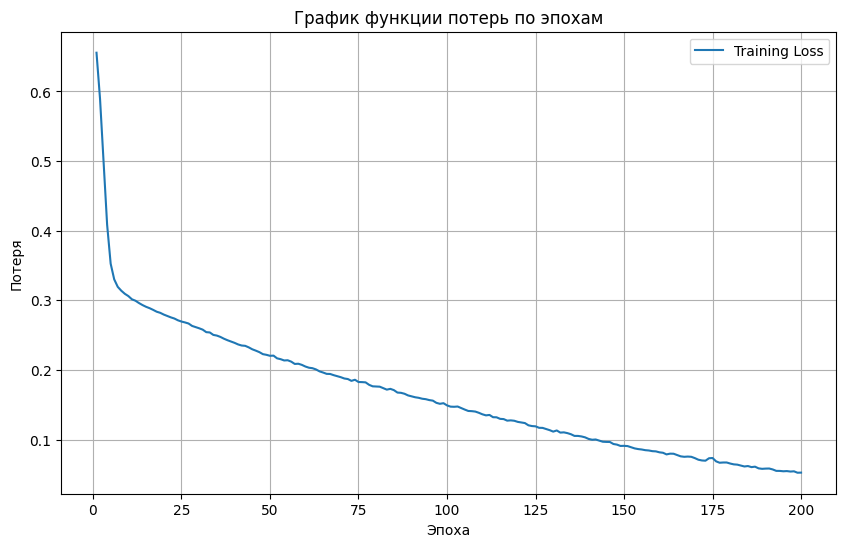

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('График функции потерь по эпохам')
plt.legend()
plt.grid(True)
plt.savefig('training_loss_mlp.png')
plt.show()

## График точности по эпохам

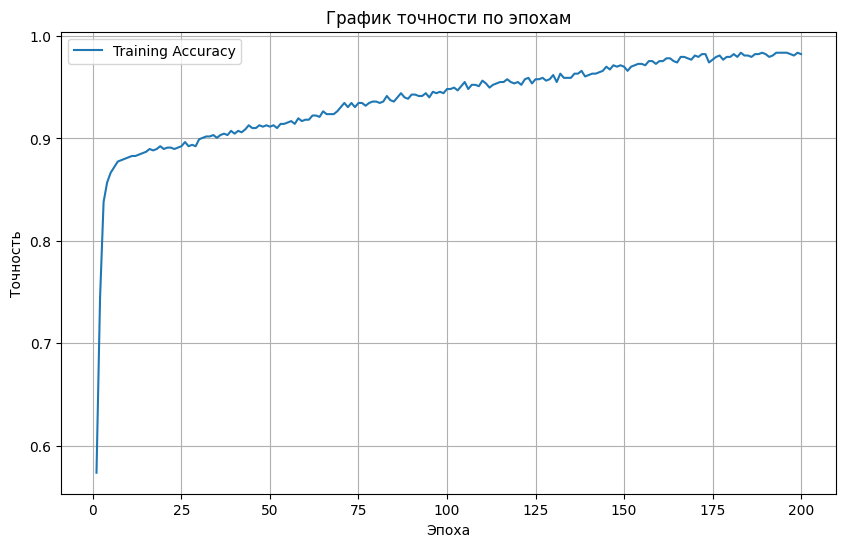

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности по эпохам')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy_mlp.png')
plt.show()

## ROC-кривая и AUC

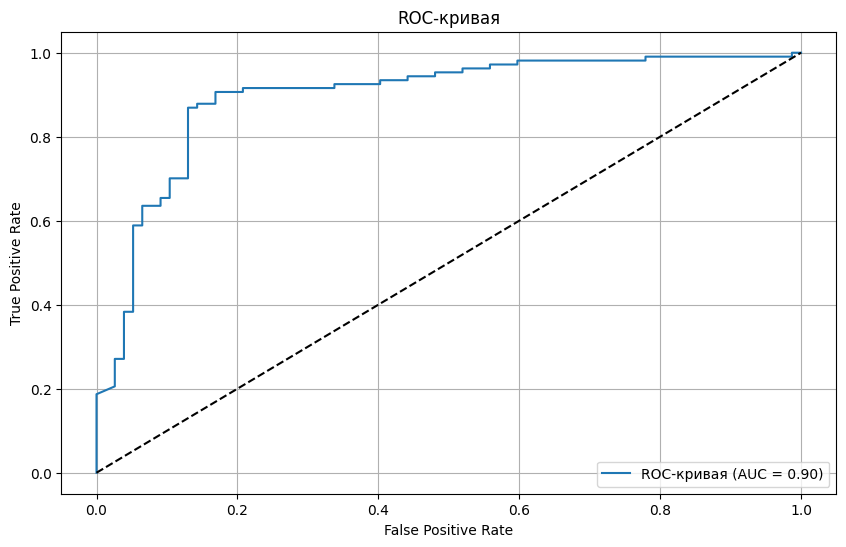

In [19]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_mlp.png')
plt.show()

## Матрица ошибок (Confusion Matrix)

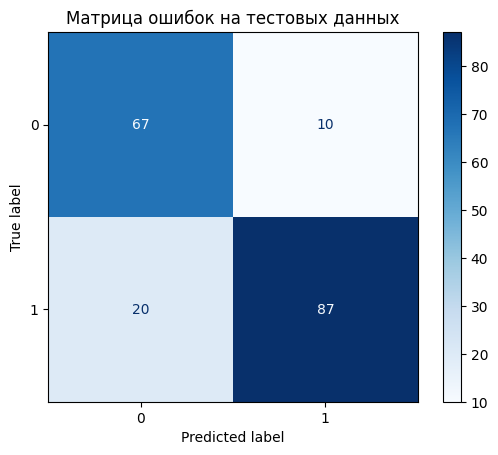

In [20]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок на тестовых данных')
plt.savefig('confusion_matrix_mlp.png')
plt.show()

# Ввод данных пользователя и предсказание

## Шаг 1: Загрузка сохранённой модели и необходимых объектов

In [21]:
class HeartNet(nn.Module):
    def __init__(self, input_size):
        super(HeartNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

# Загрузка списка признаков
with open('feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

# Загрузка уникальных значений категориальных признаков
with open('unique_values.pkl', 'rb') as f:
    unique_values = pickle.load(f)

# Загрузка скейлера
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Инициализация модели и загрузка сохранённых параметров
input_size = len(feature_columns)
model = HeartNet(input_size)
model.load_state_dict(torch.load('mlp_heartdisease_model.pth', map_location=torch.device('cpu')))
model.eval()

C:\Users\Rusod\AppData\Local\Temp\ipykernel_4136\4030106822.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mlp_heartdisease_model.pth

HeartNet(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

## Шаг 2: Функция для запроса данных у пользователя

In [22]:
def get_user_input():
    print("\nВведите данные для определения сердечного заболевания:")
    user_data = {}

    # Ввод числовых признаков
    numerical_cols = [
        ('Возраст', 'Age'),
        ('Артериальное давление в покое', 'RestingBP'),
        ('Уровень холестерина', 'Cholesterol'),
        ('Уровень сахара натощак (1: > 120 мг/дл, 0: <= 120 мг/дл)', 'FastingBS'),
        ('Максимальная ЧСС', 'MaxHR'),
        ('Oldpeak (депрессия ST)', 'Oldpeak')
    ]
    for prompt, col in numerical_cols:
        while True:
            try:
                value = float(input(f"{prompt}: "))
                user_data[col] = [value]
                break
            except ValueError:
                print("Пожалуйста, введите числовое значение.")

    # Маппинги для категориальных признаков
    sex_mapping = {'М': 'M', 'Ж': 'F'}
    chest_pain_mapping = {
        'Типичная стенокардия': 'TA',
        'Атипичная стенокардия': 'ATA',
        'Неангинозная боль': 'NAP',
        'Бессимптомная': 'ASY'
    }
    resting_ecg_mapping = {
        'Нормальная': 'Normal',
        'Аномалия ST-T': 'ST',
        'Гипертрофия ЛЖ': 'LVH'
    }
    exercise_angina_mapping = {'Да': 'Y', 'Нет': 'N'}
    st_slope_mapping = {
        'Восходящий': 'Up',
        'Горизонтальный': 'Flat',
        'Нисходящий': 'Down'
    }

    # Ввод категориальных признаков
    categorical_cols = [
        ('Пол', 'Sex', sex_mapping),
        ('Тип боли в груди', 'ChestPainType', chest_pain_mapping),
        ('ЭКГ в покое', 'RestingECG', resting_ecg_mapping),
        ('Стенокардия при нагрузке', 'ExerciseAngina', exercise_angina_mapping),
        ('Наклон сегмента ST', 'ST_Slope', st_slope_mapping)
    ]
    for prompt, col, mapping in categorical_cols:
        options = list(mapping.keys())
        print(f"Доступные варианты для {prompt}: {options}")
        value = input(f"{prompt}: ").strip()
        while value not in options:
            print(f"Некорректное значение. Пожалуйста, выберите из {options}")
            value = input(f"{prompt}: ").strip()
        user_data[col] = [mapping[value]]

    # Создание DataFrame
    user_df = pd.DataFrame(user_data)
    return user_df

## Шаг 3: Получение и предобработка пользовательских данных

In [23]:
user_input = get_user_input()

# One-Hot кодирование категориальных переменных
user_input_encoded = pd.get_dummies(user_input, columns=unique_values.keys())

# Добавление отсутствующих столбцов и упорядочивание столбцов
missing_cols = set(feature_columns) - set(user_input_encoded.columns)
for col in missing_cols:
    user_input_encoded[col] = 0
user_input_encoded = user_input_encoded[feature_columns]

# Масштабирование данных
user_input_scaled = scaler.transform(user_input_encoded)

# Преобразование в тензор
user_input_tensor = torch.tensor(user_input_scaled, dtype=torch.float32)


Введите данные для определения сердечного заболевания:


Возраст:  43
Артериальное давление в покое:  140
Уровень холестерина:  243
Уровень сахара натощак (1: > 120 мг/дл, 0: <= 120 мг/дл):  0
Максимальная ЧСС:  93
Oldpeak (депрессия ST):  1


Доступные варианты для Пол: ['М', 'Ж']


Пол:  М


Доступные варианты для Тип боли в груди: ['Типичная стенокардия', 'Атипичная стенокардия', 'Неангинозная боль', 'Бессимптомная']


Тип боли в груди:  Типичная стенокардия


Доступные варианты для ЭКГ в покое: ['Нормальная', 'Аномалия ST-T', 'Гипертрофия ЛЖ']


ЭКГ в покое:  Нормальная


Доступные варианты для Стенокардия при нагрузке: ['Да', 'Нет']


Стенокардия при нагрузке:  Да


Доступные варианты для Наклон сегмента ST: ['Восходящий', 'Горизонтальный', 'Нисходящий']


Наклон сегмента ST:  Нисходящий


## Шаг 4: Предсказание модели

In [24]:
with torch.no_grad():
    output = model(user_input_tensor)
    prediction = (output > 0.5).float()
    result = prediction.item()

## Шаг 5: Вывод результата

In [25]:
if result == 1.0:
    print("\nМодель предсказывает: Вероятно наличие сердечного заболевания.")
else:
    print("\nМодель предсказывает: Вероятно отсутствие сердечного заболевания.")


Модель предсказывает: Вероятно наличие сердечного заболевания.
